In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from lightgbm.sklearn import LGBMRegressor 
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pickle

In [2]:
data=pd.read_csv('../input/train.csv',encoding='latin-1')

In [3]:
#id: only for test & sample submission files, id for prediction sample identification
#price: price in USD
#carat: weight of the diamond
#cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
#color: diamond colour, from J (worst) to D (best)
#clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
#x: length in mm
#y: width in mm
#z: depth in mm
#depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
#table: width of top of diamond relative to widest point (43--95)

In [4]:
#We will look at the data in order to understand it

In [5]:
data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.12,Premium,H,SI1,61.6,59.0,6.67,6.63,4.10,5363
1,1,1.14,Very Good,E,SI2,60.0,54.0,6.74,6.97,4.11,5593
2,2,0.90,Very Good,D,SI2,60.3,63.0,6.12,6.22,3.72,3534
3,3,0.71,Ideal,E,VS1,61.9,54.0,5.74,5.76,3.56,3212
4,4,0.34,Very Good,F,SI2,60.0,62.0,4.51,4.55,2.72,447


In [6]:
data.shape

(40455, 11)

In [7]:
data.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

In [8]:
data.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [9]:
data=data.drop_duplicates()

In [10]:
#There are not null values, neither duplicates

In [11]:
data['cut'].value_counts()

Ideal        16250
Premium      10342
Very Good     9026
Good          3639
Fair          1198
Name: cut, dtype: int64

In [12]:
data['color'].value_counts()

G    8565
E    7344
F    7162
H    6147
D    5063
I    4052
J    2122
Name: color, dtype: int64

In [13]:
data['clarity'].value_counts()

SI1     9806
VS2     9204
SI2     6865
VS1     6099
VVS2    3778
VVS1    2776
IF      1365
I1       562
Name: clarity, dtype: int64

In [14]:
#We want to check the price of the diamonds, just in case we want to split data according to those values afterwards

In [15]:
data.sort_values(by='price',ascending=False).head(10)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
14955,14955,2.00,Very Good,G,SI1,63.5,56.0,7.90,7.97,5.04,18818
25017,25017,2.07,Ideal,G,SI2,62.5,55.0,8.20,8.13,5.11,18804
14089,14089,2.00,Very Good,H,SI1,62.8,57.0,7.95,8.00,5.01,18803
18387,18387,2.29,Premium,I,SI1,61.8,59.0,8.52,8.45,5.24,18797
5933,5933,2.04,Premium,H,SI1,58.1,60.0,8.37,8.28,4.84,18795
29475,29475,2.00,Premium,I,VS1,60.8,59.0,8.13,8.02,4.91,18795
36991,36991,1.71,Premium,F,VS2,62.3,59.0,7.57,7.53,4.70,18791
20794,20794,2.15,Ideal,G,SI2,62.6,54.0,8.29,8.35,5.21,18791
28955,28955,2.05,Ideal,G,SI1,61.9,57.0,8.10,8.16,5.03,18787
37011,37011,2.05,Premium,F,SI2,60.2,59.0,8.28,8.33,5.00,18784


In [16]:
dataplot=data.sort_values(by='price',ascending=True).reset_index()

In [17]:
dataplot=dataplot.reset_index()

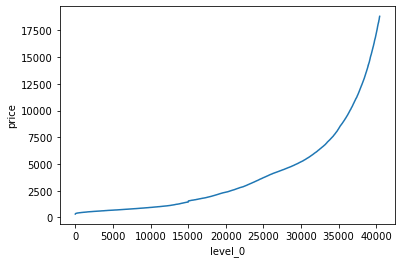

In [18]:
sns.lineplot(dataplot['level_0'],dataplot['price'])

In [19]:
#Let's see the correlation matrix of the parameters we want to use

In [20]:
data_train=data.drop(['id','price'],axis=1)

In [21]:
columns={'cut','color','clarity'}

In [22]:
for column in columns:
    le = preprocessing.LabelEncoder()
    data_train[f"{column}_ord"] = le.fit_transform(data_train[column])

In [23]:
data_train

,carat,cut,color,clarity,depth,table,x,y,z,clarity_ord,color_ord,cut_ord
0,1.12,Premium,H,SI1,61.6,59.0,6.67,6.63,4.10,2,4,3
1,1.14,Very Good,E,SI2,60.0,54.0,6.74,6.97,4.11,3,1,4
2,0.90,Very Good,D,SI2,60.3,63.0,6.12,6.22,3.72,3,0,4
3,0.71,Ideal,E,VS1,61.9,54.0,5.74,5.76,3.56,4,1,2
4,0.34,Very Good,F,SI2,60.0,62.0,4.51,4.55,2.72,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0.90,Good,D,SI1,63.8,58.0,6.13,6.09,3.90,2,0,1
40451,0.35,Ideal,D,VVS1,62.0,54.0,4.56,4.57,2.83,6,0,2
40452,0.90,Good,G,SI2,58.4,55.0,6.34,6.39,3.72,3,3,1
40453,1.21,Good,H,SI1,63.6,56.0,6.63,6.68,4.23,2,4,1


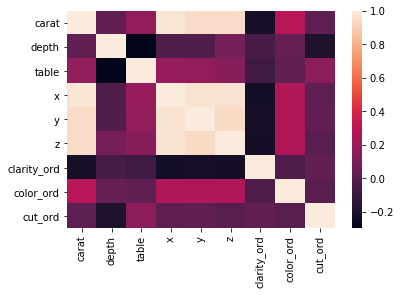

In [24]:
sns.heatmap(data_train.drop(['cut','color','clarity'],axis=1).corr())

In [25]:
#This give us the hint to exclude x,y,z from the model, in order not to have an overfitted one, because they are
#strongly relationated with caract

In [26]:
X=data_train.drop(['cut','color','clarity'],axis=1)

In [27]:
X.head()

,carat,depth,table,x,y,z,clarity_ord,color_ord,cut_ord
0,1.12,61.6,59.0,6.67,6.63,4.10,2,4,3
1,1.14,60.0,54.0,6.74,6.97,4.11,3,1,4
2,0.90,60.3,63.0,6.12,6.22,3.72,3,0,4
3,0.71,61.9,54.0,5.74,5.76,3.56,4,1,2
4,0.34,60.0,62.0,4.51,4.55,2.72,3,2,4


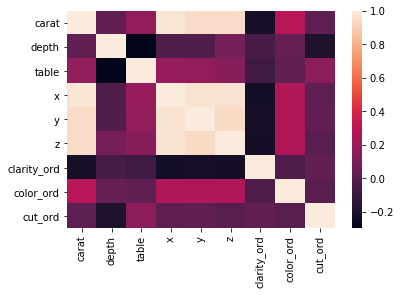

In [28]:
sns.heatmap(X.corr())

In [29]:
X.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'clarity_ord', 'color_ord',
       'cut_ord'],
      dtype='object')

In [30]:
X=pd.get_dummies(X)

In [31]:
y=data['price']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

### We train our model

In [33]:
num_folds = 10
scoring="r2"
scoring2 ="neg_root_mean_squared_error"

LGBM = LGBMRegressor(num_leaves= 35,learning_rate=0.05,
          n_estimators=400,
          min_child_weight=0.9,
          colsample_bytree= 0.9, n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
cv_results = cross_val_score(LGBM, X_train, y_train, cv=kfold,    scoring=scoring, verbose=1)
cv_results2 = cross_val_score(LGBM, X_train, y_train, cv=kfold,    scoring=scoring2, verbose=1)
print(f"-------LGBM-------")
print('Train:')
print("r2:",cv_results.mean())
print("RMSE:",-cv_results2.mean())
cv_results_test = cross_val_score(LGBM, X_test, y_test, cv=kfold,    scoring=scoring, verbose=1)
cv_results_test2 = cross_val_score(LGBM, X_test, y_test, cv=kfold,    scoring=scoring2, verbose=1)
print('Test:')
print("r2:",cv_results_test.mean())
print("RMSE:",-cv_results_test2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-------LGBM-------
Train:
r2: 0.9814330193818199
RMSE: 546.3852488864055


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test:
r2: 0.9728611322669612
RMSE: 640.2655005362346


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


### As results are acceptable, we will run the model for the entire dataset

In [36]:
LGBM.fit(X,y)

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, min_child_weight=0.9,
              n_estimators=400, num_leaves=35)

### We save our model to use it afterwards

In [37]:
filename = '../output/LGBM_model_2.sav'
pickle.dump(LGBM, open(filename, 'wb'))

In [38]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Data test dataset importation before final prediction

In [39]:
data_test=pd.read_csv('../input/predict.csv',encoding='latin-1')

In [40]:
data_test=data_test.drop(['id'],axis=1)

In [41]:
data_test.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [42]:
data_test.shape

(13485, 9)

In [43]:
columns={'cut','color','clarity'}

In [44]:
for column in columns:
    le = preprocessing.LabelEncoder()
    data_test[f"{column}_ord"] = le.fit_transform(data_test[column])

In [45]:
X_final=data_test.drop(['cut','color','clarity'],axis=1)

In [46]:
X_final=pd.get_dummies(X_final)

In [47]:
X_final.head()

,carat,depth,table,x,y,z,cut_ord,color_ord,clarity_ord
0,0.33,62.0,58.0,4.44,4.46,2.76,4,5,1
1,1.21,62.4,58.0,6.77,6.83,4.24,4,0,3
2,1.06,59.3,60.0,6.64,6.71,3.96,4,0,2
3,0.36,61.4,57.0,4.64,4.61,2.54,2,1,6
4,0.70,62.3,54.0,5.67,5.72,3.55,2,1,4


In [48]:
X_final.shape

(13485, 9)

### Price prediction with defined model

In [49]:
y_pred_final=LGBM.predict(X_final)

In [50]:
y_pred_final

array([ 710.56287866, 6060.3565176 , 5897.90460664, ..., 2499.68957948,
       1299.06192821, 1212.00453693])

### Submission generator

In [51]:
submission=pd.DataFrame(data=y_pred_final).reset_index()

In [52]:
submission=submission.rename(columns={"index":"id",0: "price"})

In [53]:
submission.head()

,id,price
0,0,710.562879
1,1,6060.356518
2,2,5897.904607
3,3,1199.785999
4,4,3189.896778


In [54]:
submission.to_csv('../output/submission_LGBM2.csv',columns=['id','price'],index=False)  